# Classify 2D shapes

- SELU instead of RELU?
- weight initialisation?

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
from cnn_util import conv_dims, pool_dims

# from data_load import ShapeDimensionDataset
#import regression


In [112]:
data_dir = 'dataset'
BATCH_SIZE = 32

In [113]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [114]:
dlt = dataloaders['train']
dst = image_datasets['train']
dst.classes


['C2', 'I1', 'L2', 'Z3', 'Z5', 'Z8', 'Z9']

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.8/shutil.py", line 719, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 717, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-h2vge_43'


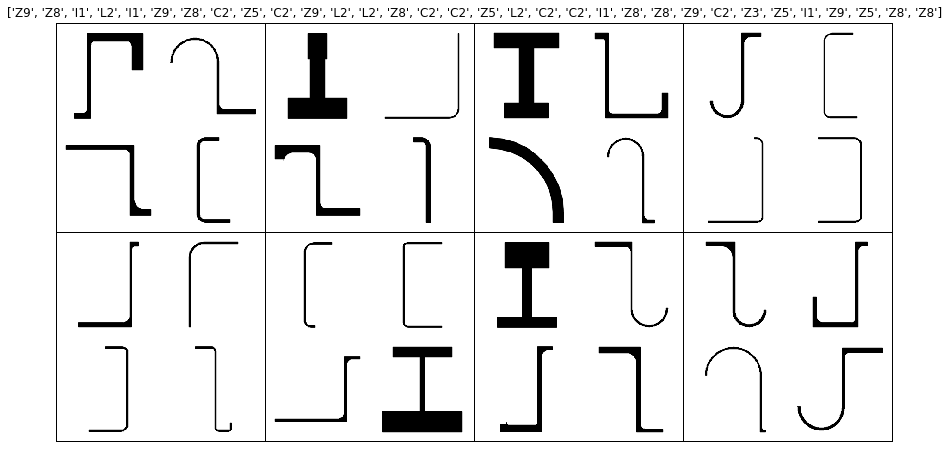

In [115]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(inp, cmap="gray")
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()
    ax.grid(False)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], )

In [116]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [118]:

class ClfNet(nn.Module):
    
    def __init__(self, output_size, image_size=224, param_names=[], description=""):
        super(ClfNet, self).__init__()
        
        self.image_size = image_size
        self.output_size = output_size
        self.description = description
        self.param_names = param_names
        
        # first convolution
        i1, m1, n1 = self.image_size, 1, 8    # input size, num features in, num out
        k1, s1, p1 = 5, 2, 0              # kernel size, stride, padding
        o1 = conv_dims(i1, k1, s1, p1)    # output size
        # first pooling
        kp1, sp1 = 2, 2                   # kernel size, stride  
        op1 = pool_dims(o1, kp1, sp1)     # output size
        # second convolution
        i2, m2, n2 = op1, n1, 16          # input size, num features in, num out
        k2, s2, p2 = 3, 1, 0              # kernel size, stride, padding
        o2 = conv_dims(i2, k2, s2, p2)    # output size
        # second pooling
        kp2, sp2 = 2, 2                   # kernel size, stride
        op2 = pool_dims(o2, kp2, sp2)     # output size

        # fully connected layers
        self.mh0 = n2 * op2**2            # needed later - size of first linear layer
        mh1 = 1000                        # input size of second fully connected layer        
        mh2 = 100                          # input size of second fully connected layer        
        
        self.conv1 = nn.Conv2d(m1, n1, k1, stride=s1, padding=p1)
        self.conv2 = nn.Conv2d(m2, n2, k2, stride=s2, padding=p2)
        self.pool1 = nn.MaxPool2d(kp1, stride=sp1)
        self.pool2 = nn.MaxPool2d(kp2, stride=sp2)        

        self.fc1 = nn.Linear(self.mh0, mh1)
        self.fc2 = nn.Linear(mh1, mh2)
        self.fc3 = nn.Linear(mh2, self.output_size)
        
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self.mh0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    
    def save_checkpoint(self, fpath):
        checkpoint = {
            "state_dict": self.state_dict(),
            "image_size": self.image_size,
            "output_size": self.output_size,
            "param_names": self.param_names,
            "description": self.description,
            # "history": epochs,
            # "lr": lr,
            #"optimizer_state_dict": optimizer.state_dict()
        }
        torch.save(checkpoint, fpath)        
    
    
    @staticmethod
    def from_checkpoint(fpath):
        checkpoint = torch.load(fpath, map_location='cpu')
        print(checkpoint["description"])
        print("Input size: %g, output size: %g" % (checkpoint['image_size'], 
                                                   checkpoint['output_size']))
        print("parameter names: %s" % ", ".join(checkpoint['param_names']))

        model = Net1(checkpoint['output_size'], 
                     checkpoint['image_size'], 
                     description=checkpoint['description'], 
                     param_names=checkpoint['param_names'],
                    )
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        return model

In [9]:
num_classes = len(dst.classes)
model = ClfNet(num_classes)
model = model.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/1369 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.3023 Acc: 0.8786


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0932 Acc: 0.9644

Epoch 1/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0793 Acc: 0.9679


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0993 Acc: 0.9606

Epoch 2/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0481 Acc: 0.9812


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0377 Acc: 0.9856

Epoch 3/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0225 Acc: 0.9923


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0196 Acc: 0.9933

Epoch 4/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0159 Acc: 0.9949


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0247 Acc: 0.9915

Epoch 5/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0120 Acc: 0.9962


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0142 Acc: 0.9957

Epoch 6/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0090 Acc: 0.9969


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0137 Acc: 0.9960

Epoch 7/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0018 Acc: 0.9994


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0026 Acc: 0.9994

Epoch 8/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9997


  0%|          | 0/1369 [00:00<?, ?it/s]

val Loss: 0.0015 Acc: 0.9995

Epoch 9/9
----------


  0%|          | 0/294 [00:00<?, ?it/s]

train Loss: 0.0010 Acc: 0.9998


100%|██████████| 294/294 [00:14<00:00, 20.81it/s]

val Loss: 0.0015 Acc: 0.9995

Training complete in 50m 22s
Best val Acc: 0.999467


In [11]:
model.save_checkpoint("models/classifier1.pt")

In [166]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            preds = logits.argmax(dim=1).numpy()    

            #fig = plt.Figure()
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(inputs[j,0], cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    return fig

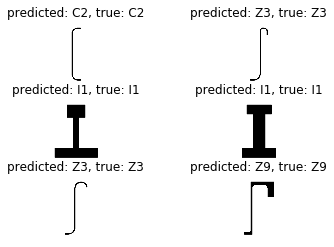

In [173]:
visualize_model(model)

## Evaluation
- Run prediction on all validation examples. 
- show misclassified items
- make confusion matrix

In [86]:
from PIL import Image

xfo = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

def predict(model, fpath, classnames):
    """run model on a file, return class label"""
    img = Image.open(fpath)
    inp = xfo(img)
    inp = inp.expand((1,) + inp.shape) # because it's just one image
    with torch.no_grad():
        logits = model(inp)
        icls = logits.argmax().numpy()
    return classnames[icls]

In [181]:
import glob
import pandas as pd

filenames = glob.glob("dataset/test/*/*.png")
true_labels = [fname.split("/")[2] for fname in filenames]

In [186]:
class_names = np.array(image_datasets['train'].classes)
predicted_labels = [predict(model, fn, class_names) for fn in filenames]

In [187]:
df_eval = pd.DataFrame({'fname': filenames, 'true': true_labels, 'pred': predicted_labels})
df_eval.query("true != pred")

,fname,true,pred
4775,dataset/test/Z9/2671.png,Z9,Z5
5578,dataset/test/Z9/4090.png,Z9,Z5
5890,dataset/test/Z9/4704.png,Z9,Z5
6146,dataset/test/L2/3751.png,L2,Z5
7837,dataset/test/Z5/2785.png,Z5,Z9


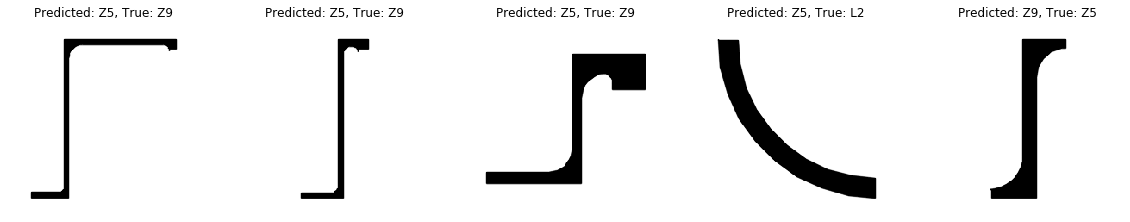

In [188]:
import cv2
misclassified = df_eval.query("true != pred")
n_mc = len(misclassified)

fig, axes = plt.subplots(1, n_mc, figsize=(20,10))
for i, t in enumerate(misclassified.itertuples()):
    img = cv2.imread(t.fname)
    axes[i].imshow(img)
    axes[i].set_title('Predicted: {}, True: {}'.format(t.pred, t.true))
    axes[i].set_axis_off()

In [189]:
len(true_labels)

9384